In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/sugarcane_dataset'

2.20.0


In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=16
)

val_data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=16
)

In [ ]:
class_names = train_data.class_names
print(f"Detected classes: {class_names}")


Found 612 files belonging to 3 classes.
Using 490 files for training.
Found 612 files belonging to 3 classes.
Using 122 files for validation.


In [ ]:
with open('/content/drive/MyDrive/class_names.json', 'w') as f:
    json.dump(class_names, f)
print("class_names.json has been saved to Drive!")

['Healthy', 'Mosaic', 'redrot']


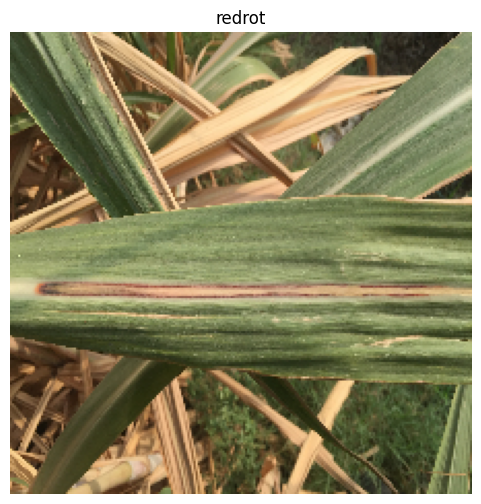

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [ ]:
train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))
train_data = train_data.map(lambda x, y: (preprocess_input(x), y))
val_data = val_data.map(lambda x, y: (preprocess_input(x), y))


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False) # training=False ensures batchnorm stays in inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop]
)

In [ ]:
model.save('/content/drive/MyDrive/sugarcane_model.keras')
print("Model saved successfully!")

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 32s 571ms/step - accuracy: 0.7551 - loss: 0.6974 - val_accuracy: 0.7377 - val_loss: 0.6026
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 469ms/step - accuracy: 0.8714 - loss: 0.3686 - val_accuracy: 0.7377 - val_loss: 0.6535
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 480ms/step - accuracy: 0.9061 - loss: 0.2413 - val_accuracy: 0.7623 - val_loss: 0.6353
Epoch 4/20


KeyboardInterrupt: 